Logistic regression models the relationship between one or more predictor variables $X_1, X_2, ..., X_N$ and a binary target variable $Y$ (0 or 1). Unlike linear regression, logistic regression models the **log-odds** of $Y=1$ using the logistic function:

$$
p(Y=1) = \frac{e^{\beta_0 + \beta_1 X_1 + ... + \beta_N X_N}}{1 + e^{\beta_0 + \beta_1 X_1 + ... + \beta_N X_N}}.
$$

Equivalently, the **odds ratio** can be written as:

$$
\frac{p(Y=1)}{p(Y=0)} = e^{\beta_0 + \beta_1 X_1 + ... + \beta_N X_N}.
$$

Taking the logarithm of both sides gives the **log-odds**, which is linear in the predictors:

$$
\ln \left( \frac{p(Y=1)}{p(Y=0)} \right) = \beta_0 + \beta_1 X_1 + ... + \beta_N X_N.
$$

For a single binary predictor $X_1$:

$$
\frac{p(Y=1 \mid X_1=1)}{p(Y=1 \mid X_1=0)} = e^{\beta_1}.
$$

This shows that $e^{\beta_1}$ represents the **odds ratio** of $Y=1$ when $X_1=1$ versus $X_1=0$.

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import statsmodels.api as sm

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
#train data
loan_inputs_train = pd.read_csv('data/loan_inputs_train.csv', index_col=0)
loan_target_train = pd.read_csv('data/loan_target_train.csv', index_col=0)

#test data
loan_inputs_test = pd.read_csv('data/loan_inputs_test.csv', index_col=0)
loan_target_test = pd.read_csv('data/loan_target_test.csv', index_col=0)

In [3]:
loan_inputs_train.shape

(400000, 324)

In [4]:
loan_inputs_test.shape

(100000, 324)

First, we import reference categories that we made earlier from `dummy_variable.txt`

In [5]:
with open('dummy_variables.txt') as f:
    all_cols = [line.strip() for line in f] #all columns

with open('ref_variables.txt') as f:
    ref_cols = [line.strip() for line in f] #reference columns (safest baseline variables)

In [6]:
inputs_train_w_ref_cols = loan_inputs_train.loc[:, all_cols]
inputs_train = inputs_train_w_ref_cols.drop(ref_cols, axis=1)
inputs_train.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,home_ownership:RENT,home_ownership:OWN_ANY,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
269056,False,False,False,False,False,False,False,0,0,0,...,0,0,0,0,0,0,0,1,0,0
499174,True,False,False,False,False,True,False,1,0,0,...,0,0,0,0,0,0,0,0,0,0
85143,False,False,False,False,False,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260335,False,False,False,False,False,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338124,True,False,False,False,False,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
inputs_train_num = inputs_train.apply(pd.to_numeric, errors='coerce')
loan_target_train_num = pd.to_numeric(loan_target_train['good_bad'], errors='coerce')

Note: We use `statsmodels` to perfom logistic fit since we prefer expolartive modeling, rather than predcitive modelling as offered by `sklearn`. Another advantge is `statsmodels` automatically returns the p-values. 

In [8]:
x = sm.add_constant(inputs_train_num.astype(float))
y = loan_target_train_num.astype(float)

reg_log = sm.Logit(y, x)
pd_model = reg_log.fit() # Note: fit needs parentheses ()
print(pd_model.summary())

Optimization terminated successfully.
         Current function value: 0.065974
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               good_bad   No. Observations:               400000
Model:                          Logit   Df Residuals:                   399948
Method:                           MLE   Df Model:                           51
Date:                Wed, 11 Feb 2026   Pseudo R-squ.:                 0.05618
Time:                        21:12:26   Log-Likelihood:                -26390.
converged:                       True   LL-Null:                       -27961.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   5.2563      0.718

# Interpreting the coefficients of logistic regression

Here, the coefficients raised to the exponenet indicate the odds of someone defaulting if they have the feature. That is
$$
\frac{p(Y=1|X_i=1)}{p(Y=1|X_i=0)} = e^{\beta_{X_i}}
$$
We can also two different dummy variables as long as they are mutually exclusive
$$
\frac{p(Y=1|X_i=1)}{p(Y=1|X_j=1)} = e^{\beta_{X_i}-\beta_{X_j}}
$$

The fit also returns p-values, based on which we revise our categories

In [9]:
with open("fit_results.txt", "w") as f: #write results to txt file
    f.write(pd_model.summary().as_text())

# Refit
We do a refit by observing the p-values of our fit. So we remove `home_ownership` entirely for low p-values.

In [10]:
with open('dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

In [11]:
inputs_train_w_ref_cols_revised = loan_inputs_train.loc[:, all_cols_revised]
inputs_train = inputs_train_w_ref_cols_revised.drop(ref_cols_revised, axis=1)
inputs_train.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
269056,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
499174,True,False,False,False,False,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85143,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260335,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338124,True,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
inputs_train_num = inputs_train.apply(pd.to_numeric, errors='coerce')
loan_target_train_num = pd.to_numeric(loan_target_train['good_bad'], errors='coerce')

x = sm.add_constant(inputs_train_num.astype(float))
y = loan_target_train_num.astype(float)

logit_model = sm.Logit(y, x)
pd_model = logit_model.fit() # Note: fit needs parentheses ()
print(pd_model.summary())

Optimization terminated successfully.
         Current function value: 0.066020
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               good_bad   No. Observations:               400000
Model:                          Logit   Df Residuals:                   399950
Method:                           MLE   Df Model:                           49
Date:                Wed, 11 Feb 2026   Pseudo R-squ.:                 0.05553
Time:                        21:12:39   Log-Likelihood:                -26408.
converged:                       True   LL-Null:                       -27961.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   5.1539      0.718

Therefore, our PD model is statistically robust and consistent. Key risk drivers are credit grade, delinquency history, debt burden, and employment stability, which exhibit monotonic and significant relationships with default risk.

In [13]:
with open("fit_results_revised.txt", "w") as f:
    f.write(pd_model.summary().as_text())

# PD model validation

Out-of-sample validation

In [14]:
with open('dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)


inputs_test_w_ref_cols = loan_inputs_test.loc[:, all_cols_revised]
inputs_test = inputs_test_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_test.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
104241,True,False,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
199676,False,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140199,False,False,True,False,False,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
132814,True,False,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
408697,False,False,True,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
inputs_test_num = inputs_test.apply(pd.to_numeric, errors='coerce')
loan_target_test_num = pd.to_numeric(loan_target_test['good_bad'], errors='coerce')

X_test_const = sm.add_constant(inputs_test.astype(float))
y_pred_prob = pd_model.predict(X_test_const)  
y_pred_class = (y_pred_prob >= 0.5).astype(int) 

# Accuracy
accuracy = accuracy_score(loan_target_test_num, y_pred_class)

# ROC-AUC
roc_auc = roc_auc_score(loan_target_test_num, y_pred_prob)

# Confusion matrix
cm = confusion_matrix(loan_target_test_num, y_pred_class)

# Detailed classification report
report = classification_report(loan_target_test_num, y_pred_class)

print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.98675
ROC-AUC: 0.7097464613678408
Confusion Matrix:
 [[    0  1325]
 [    0 98675]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1325
           1       0.99      1.00      0.99     98675

    accuracy                           0.99    100000
   macro avg       0.49      0.50      0.50    100000
weighted avg       0.97      0.99      0.98    100000



Although we have an accuracy of 97% with 0.5 threshold, PD model predicts everything as positive with no bad borrower. It does not have any bad cases (true or false). So we take a more conservative threshold 0.95

In [ ]:
inputs_test_num = inputs_test.apply(pd.to_numeric, errors='coerce')
loan_target_test_num = pd.to_numeric(loan_target_test['good_bad'], errors='coerce')

X_test_const = sm.add_constant(inputs_test.astype(float))
y_pred_prob = pd_model.predict(X_test_const)  
y_pred_class = (y_pred_prob >= 0.95).astype(int) 

# Accuracy
accuracy = accuracy_score(loan_target_test_num, y_pred_class)

# Confusion matrix
cm = confusion_matrix(loan_target_test_num, y_pred_class)

# Detailed classification report
report = classification_report(loan_target_test_num, y_pred_class)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.97653
Confusion Matrix:
 [[   54  1271]
 [ 1076 97599]]
Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.04      0.04      1325
           1       0.99      0.99      0.99     98675

    accuracy                           0.98    100000
   macro avg       0.52      0.51      0.52    100000
weighted avg       0.97      0.98      0.98    100000



- Now the PD model has slighly less accuracy but it detects 54 true negatives. The number for true and false positives are almost the same. 

- **This is imporant for buisness logic, where we want to decrease false positives and negatives to avoid losses and increase profitability, respectively.**

So now we turn to ROC curve, which plots TP against FP for all thresholds

ROC-AUC: 0.7097464613678408


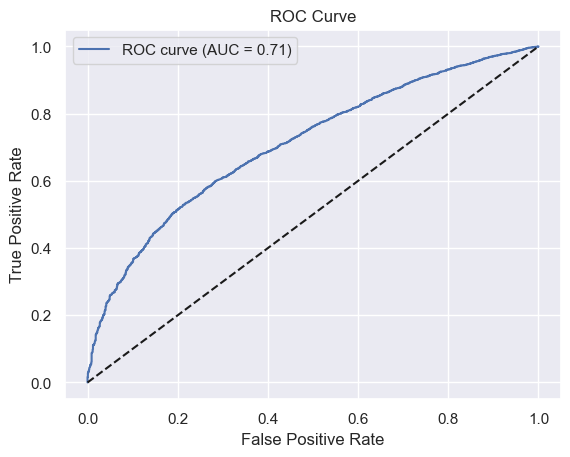

In [17]:
# ROC-AUC
roc_auc = roc_auc_score(loan_target_test_num, y_pred_prob)
print("ROC-AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(loan_target_test_num, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

- Each point of the ROC curve denotes a confusion matrix.

- Straight dashed line in ROC curve shows perfect discrimination. 

- Since our curve is higher than straight dashed line means our PD model is better at guessing than by taking random guesses.

- Overall ROC-AUC=0.71 suggests our model is fair, but still there is room for improvement.

In [18]:
gini = 2 * roc_auc - 1
print("Gini coefficient:", gini)

Gini coefficient: 0.4194929227356816


In [19]:
pos_probs = y_pred_prob[loan_target_test_num == 1]
neg_probs = y_pred_prob[loan_target_test_num == 0]

# Compute CDFs
pos_cdf = np.sort(pos_probs)
neg_cdf = np.sort(neg_probs)

# Cumulative distributions
pos_cum = np.arange(1, len(pos_cdf)+1) / len(pos_cdf)
neg_cum = np.arange(1, len(neg_cdf)+1) / len(neg_cdf)

# Interpolate CDFs onto a common set of points
all_probs = np.sort(np.concatenate([pos_cdf, neg_cdf]))
pos_interp = np.searchsorted(pos_cdf, all_probs, side='right') / len(pos_cdf)
neg_interp = np.searchsorted(neg_cdf, all_probs, side='right') / len(neg_cdf)

# KS statistic
ks_stat = np.max(np.abs(pos_interp - neg_interp))
print("KS statistic:", ks_stat)

KS statistic: 0.3164426767881983


# Creating a Scorecard

Now we use fit results to define a scoercard that is easy to use. First we combine reference categories (baseline safe) with main dataframe to create a scorecard dataframe `df_scorecard`.

In [20]:
features_name = inputs_train.columns.values
coeff_values = pd_model.params.values
pvals_values = pd_model.pvalues.values

# Build table including intercept
summary_table = pd.DataFrame({
    'Feature name': ['Intercept'] + list(features_name),
    'Coefficients': coeff_values,
    'p_values': pvals_values
})

summary_table

,Feature name,Coefficients,p_values
0,Intercept,5.153879,7.162513e-13
1,grade:B,-0.804419,2.593232e-01
2,grade:C,-1.342298,6.004251e-02
3,grade:D,-1.683893,1.835153e-02
4,grade:E,-1.695754,1.810815e-02
5,grade:F_G,-1.898531,8.451670e-03
6,addr_state:HI_MS_OK_AL,-0.108958,1.644079e-01
7,addr_state:NY_FL,-0.067462,1.624429e-01
8,addr_state:NM_SD_NV,0.014775,8.760589e-01
9,addr_state:MD_MI_NC,0.014693,8.058680e-01


In [21]:
df_ref_cat = pd.DataFrame(ref_cols_revised, columns=['Feature name'])
df_ref_cat['Coefficients'] = 0
df_ref_cat['p_values'] = np.nan
df_ref_cat

,Feature name,Coefficients,p_values
0,grade:A,0,NaN
1,addr_state:CA,0,NaN
2,verification_status:Not Verified,0,NaN
3,purpose:db_co,0,NaN
4,initial_list_status:w,0,NaN
5,term:36,0,NaN
6,emp_length:10,0,NaN
7,int_rate:27_31,0,NaN
8,annual_inc:90K_159K,0,NaN
9,mths_since_last_delinq:17_48,0,NaN


In [22]:
df_scorecard = pd.concat([summary_table, df_ref_cat])
df_scorecard = df_scorecard.reset_index(drop=True)
df_scorecard.tail(20)

,Feature name,Coefficients,p_values
42,mths_since_last_delinq:65_70,0.184675,6.428551e-02
43,mths_since_last_delinq:70_80,-0.045882,5.561272e-01
44,mths_since_last_record:<36,-0.252998,1.087291e-01
45,mths_since_last_record:37_66,-0.164322,3.806431e-02
46,mths_since_last_record:122_127,-0.544053,5.944169e-01
47,dti:<1,-0.704995,3.463142e-12
48,dti:1_6,-0.304574,6.853279e-10
49,dti:30_40,0.000990,9.818406e-01
50,grade:A,0.000000,NaN
51,addr_state:CA,0.000000,NaN


In [23]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,Feature name,Coefficients,p_values,Original feature name
0,Intercept,5.153879,7.162513e-13,Intercept
1,grade:B,-0.804419,2.593232e-01,grade
2,grade:C,-1.342298,6.004251e-02,grade
3,grade:D,-1.683893,1.835153e-02,grade
4,grade:E,-1.695754,1.810815e-02,grade
...,...,...,...,...
57,int_rate:27_31,0.000000,NaN,int_rate
58,annual_inc:90K_159K,0.000000,NaN,annual_inc
59,mths_since_last_delinq:17_48,0.000000,NaN,mths_since_last_delinq
60,mths_since_last_record:67_121,0.000000,NaN,mths_since_last_record


With this, we create a FICO style scorecard with min credit score 300 and maximum credit score 850

In [24]:
min_score = 300
max_score = 850

In [25]:
df_scorecard.groupby('Original feature name')['Coefficients'].max()

Original feature name
Intercept                 5.153879
addr_state                0.764242
annual_inc                0.204263
dti                       0.000990
emp_length                0.000000
grade                     0.000000
initial_list_status       0.000000
int_rate                  0.784136
mths_since_last_delinq    0.184675
mths_since_last_record    0.000000
purpose                   0.109313
term                      0.065403
verification_status       0.000000
Name: Coefficients, dtype: float64

In [26]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()

print(f"max_sum_coef:{max_sum_coef:.3f}    min_sum_coef:{min_sum_coef:.3f}")

max_sum_coef:7.267    min_sum_coef:0.305


In [27]:
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients']* (max_score-min_score) / (max_sum_coef - min_sum_coef)
df_scorecard

,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,Intercept,5.153879,7.162513e-13,Intercept,407.146635
1,grade:B,-0.804419,2.593232e-01,grade,-63.547594
2,grade:C,-1.342298,6.004251e-02,grade,-106.038968
3,grade:D,-1.683893,1.835153e-02,grade,-133.024364
4,grade:E,-1.695754,1.810815e-02,grade,-133.961299
...,...,...,...,...,...
57,int_rate:27_31,0.000000,NaN,int_rate,0.000000
58,annual_inc:90K_159K,0.000000,NaN,annual_inc,0.000000
59,mths_since_last_delinq:17_48,0.000000,NaN,mths_since_last_delinq,0.000000
60,mths_since_last_record:67_121,0.000000,NaN,mths_since_last_record,0.000000


In [28]:
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef-min_sum_coef))* (max_score-min_score) + min_score
df_scorecard

,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,Intercept,5.153879,7.162513e-13,Intercept,683.075338
1,grade:B,-0.804419,2.593232e-01,grade,-63.547594
2,grade:C,-1.342298,6.004251e-02,grade,-106.038968
3,grade:D,-1.683893,1.835153e-02,grade,-133.024364
4,grade:E,-1.695754,1.810815e-02,grade,-133.961299
...,...,...,...,...,...
57,int_rate:27_31,0.000000,NaN,int_rate,0.000000
58,annual_inc:90K_159K,0.000000,NaN,annual_inc,0.000000
59,mths_since_last_delinq:17_48,0.000000,NaN,mths_since_last_delinq,0.000000
60,mths_since_last_record:67_121,0.000000,NaN,mths_since_last_record,0.000000


In [29]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,5.153879,7.162513e-13,Intercept,683.075338,683.0
1,grade:B,-0.804419,2.593232e-01,grade,-63.547594,-64.0
2,grade:C,-1.342298,6.004251e-02,grade,-106.038968,-106.0
3,grade:D,-1.683893,1.835153e-02,grade,-133.024364,-133.0
4,grade:E,-1.695754,1.810815e-02,grade,-133.961299,-134.0
...,...,...,...,...,...,...
57,int_rate:27_31,0.000000,NaN,int_rate,0.000000,0.0
58,annual_inc:90K_159K,0.000000,NaN,annual_inc,0.000000,0.0
59,mths_since_last_delinq:17_48,0.000000,NaN,mths_since_last_delinq,0.000000,0.0
60,mths_since_last_record:67_121,0.000000,NaN,mths_since_last_record,0.000000,0.0


Let's check if the max and min of our scorecard is within the FICO bounds

In [30]:
df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()

np.float64(850.0)

In [31]:
df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()

np.float64(299.0)

We get 299 instead of 300 min credit score due to rounding down error

In [32]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard.head(60)

,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,Intercept,5.153879,7.162513e-13,Intercept,683.075338,683.0,-0.075338
1,grade:B,-0.804419,2.593232e-01,grade,-63.547594,-64.0,-0.452406
2,grade:C,-1.342298,6.004251e-02,grade,-106.038968,-106.0,0.038968
3,grade:D,-1.683893,1.835153e-02,grade,-133.024364,-133.0,0.024364
4,grade:E,-1.695754,1.810815e-02,grade,-133.961299,-134.0,-0.038701
5,grade:F_G,-1.898531,8.451670e-03,grade,-149.980355,-150.0,-0.019645
6,addr_state:HI_MS_OK_AL,-0.108958,1.644079e-01,addr_state,-8.607438,-9.0,-0.392562
7,addr_state:NY_FL,-0.067462,1.624429e-01,addr_state,-5.329343,-5.0,0.329343
8,addr_state:NM_SD_NV,0.014775,8.760589e-01,addr_state,1.167175,1.0,-0.167175
9,addr_state:MD_MI_NC,0.014693,8.058680e-01,addr_state,1.160752,1.0,-0.160752


We manually override the 5th row

In [33]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[5, 'Score - Final'] = -149  

In [34]:
df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()

np.float64(300.0)

In [35]:
df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()

np.float64(850.0)

Now our scorecard matches with the FICO upper and lower bounds

In [36]:
df_scorecard

,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,5.153879,7.162513e-13,Intercept,683.075338,683.0,-0.075338,683.0
1,grade:B,-0.804419,2.593232e-01,grade,-63.547594,-64.0,-0.452406,-64.0
2,grade:C,-1.342298,6.004251e-02,grade,-106.038968,-106.0,0.038968,-106.0
3,grade:D,-1.683893,1.835153e-02,grade,-133.024364,-133.0,0.024364,-133.0
4,grade:E,-1.695754,1.810815e-02,grade,-133.961299,-134.0,-0.038701,-134.0
...,...,...,...,...,...,...,...,...
57,int_rate:27_31,0.000000,NaN,int_rate,0.000000,0.0,0.000000,0.0
58,annual_inc:90K_159K,0.000000,NaN,annual_inc,0.000000,0.0,0.000000,0.0
59,mths_since_last_delinq:17_48,0.000000,NaN,mths_since_last_delinq,0.000000,0.0,0.000000,0.0
60,mths_since_last_record:67_121,0.000000,NaN,mths_since_last_record,0.000000,0.0,0.000000,0.0


In [37]:
inputs_test_w_ref_cols.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,...,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:67_121,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:7_30,dti:30_40
104241,False,True,False,False,False,False,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
199676,True,False,False,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
140199,False,False,False,True,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
132814,False,True,False,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
408697,False,False,False,True,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [38]:
inputs_test_w_ref_cols_w_intercept = inputs_test_w_ref_cols
inputs_test_w_ref_cols_w_intercept.insert(0, 'Intercept', 1)

In [39]:
inputs_test_w_ref_cols = inputs_test_w_ref_cols[df_scorecard['Feature name'].values]
inputs_test_w_ref_cols.shape

(100000, 62)

In [40]:
scorecard_scores = df_scorecard['Score - Final']

In [41]:
scorecard_scores.shape

(62,)

In [42]:
scorecard_scores = scorecard_scores.values.reshape(62,1)
scorecard_scores.shape

(62, 1)

In [43]:
y_scores = inputs_test_w_ref_cols.dot(scorecard_scores)
y_scores.head()

,0
104241,657.0
199676,766.0
140199,581.0
132814,635.0
408697,633.0


# Setting cut-off: buisness decesion making

Finally, we would like to set a cutoff for granting or rejecting a loan. 

- If we set low cutoff and accept most people, we would accept low-quality borrowers and suffer potential losses. 

- Conversely, setting a high cutoff lends money to very few people that hurts buisness profitability.

In [44]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
df_cutoffs.head()

,thresholds,fpr,tpr
0,inf,0.0,0.000000
1,0.999070,0.0,0.000010
2,0.999025,0.0,0.000051
3,0.998970,0.0,0.000081
4,0.998907,0.0,0.000122


In [45]:
df_cutoffs = df_cutoffs.replace([np.inf, -np.inf], np.nan)
df_cutoffs.head()

,thresholds,fpr,tpr
0,NaN,0.0,0.000000
1,0.999070,0.0,0.000010
2,0.999025,0.0,0.000051
3,0.998970,0.0,0.000081
4,0.998907,0.0,0.000122


In [46]:
df_cutoffs['Score'] = (
                        (np.log(df_cutoffs['thresholds'] / (1-df_cutoffs['thresholds'])) - min_sum_coef)
                        *((max_score - min_score) / (max_sum_coef - min_sum_coef)) 
                        + min_score
                       ).round()

In [47]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,NaN,0.0,0.000000,NaN
1,0.999070,0.0,0.000010,827.0
2,0.999025,0.0,0.000051,824.0
3,0.998970,0.0,0.000081,819.0
4,0.998907,0.0,0.000122,814.0


In [48]:
def approval_rate(p, y_pred_prob):
    return (y_pred_prob < p).mean()


def rejection_rate(p, y_pred_prob):
    return (y_pred_prob >= p).mean()


df_cutoffs['approval_rate'] = df_cutoffs['thresholds'].apply(
    lambda p: approval_rate(p, y_pred_prob)
)

df_cutoffs['rejection_rate'] = df_cutoffs['thresholds'].apply(
    lambda p: rejection_rate(p, y_pred_prob)
)


In [49]:
df_cutoffs[abs(df_cutoffs['approval_rate']-0.6) < 1e-3]

,thresholds,fpr,tpr,Score,approval_rate,rejection_rate
7634,0.991548,0.126038,0.402726,652.0,0.60094,0.39906
7635,0.991548,0.126038,0.402757,652.0,0.60091,0.39909
7636,0.991547,0.126038,0.402807,652.0,0.60086,0.39914
7637,0.991547,0.126038,0.402817,652.0,0.60085,0.39915
7638,0.991546,0.126038,0.402848,652.0,0.60082,0.39918
7639,0.991544,0.126038,0.402888,652.0,0.60078,0.39922
7640,0.991543,0.126038,0.402909,652.0,0.60076,0.39924
7641,0.991541,0.126038,0.402949,652.0,0.60072,0.39928
7642,0.991540,0.126038,0.402969,652.0,0.60070,0.39930
7643,0.991540,0.126038,0.403050,652.0,0.60062,0.39938


**Therefore, we see for a 60% (e.g. mortgages) approval rate we need a cutoff score of 652**

- Anything below 652 will be rejected for loan.

- Note, credit score provide less control for setting cutoffs. This is because for a varying number of thresholds we have same credit score

Let's save results

In [50]:
inputs_test_w_ref_cols.to_csv('data/inputs_test_w_ref_cols.csv')

In [51]:
df_scorecard.to_csv('data/df_scorecard.csv')

In [52]:
df_cutoffs.to_csv('data/df_cutoffs.csv')

In [53]:
#save model
with open('data/pd_model.pkl', 'wb') as f:
    pickle.dump(pd_model, f)